# Проект по теме телекоммуникации:

**Описание проекта:**  
Для оператора связи «ТелеДом» необходимо реализовать модель, которая поможет бороться с оттоком клиентов. При квалификации клиенов, как планирующих отключиться от договора, сотрудники оператора связи «ТелеДом» начнут предлагать им промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах.   

**Задачи:**   
Задача провести предобработку данных и предварительный анализ данных, далее объеденить все необходимые для обучения данные в один датасет, провести исследовательский и корреляционный анализ данных, подготовить датасет (добавить новые данные) — и в финале обучить на этих данных модель для прогноза оттока клиентов и дать рекомендации для бизнеса.    

**Цель исследования** :  
Обучить модель, которая будет предсказывать клиентов, которые планируют отключиться от договора.  
Дать рекомендации для бизнеса, за какими показателями нужно более пристально наблюдать.

# Шаг 1. Загрузка данных

Подготовим необходимые импорты

In [ ]:
import pandas as pd
import os
import time
import numpy as np
import matplotlib.pyplot as plt
!pip install phik -q
!pip install --upgrade scikit-learn -q
import phik
from phik.report import plot_correlation_matrix
from dateutil.relativedelta import relativedelta
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, precision_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


#Задаем константы
RANDOM_STATE = 300625

#Пути к файлам
DATA_FILES = {
    'contract': 'contract_new.csv',
    'personal': 'personal_new.csv',
    'internet': 'internet_new.csv',
    'phone': 'phone_new.csv'
}

#Конфигурация путей
BASE_LOCAL_PATH = './'  # Текущая директория
BASE_NETWORK_URL = 'https://code.s3.yandex.net/datasets/'

#Дата выгрузки данных
REFERENCE_DATE = pd.to_datetime('2020-02-01')

Считываем данные из предоставленных датасетов

In [ ]:
#Функция загрузки файлов
def load_dataset(file_name, date_columns=None):
    local_path = os.path.join(BASE_LOCAL_PATH, file_name)
    network_path = BASE_NETWORK_URL + file_name

    try:
#Загружаем файл локально
        if os.path.exists(local_path):
            display (f"Загружаем {file_name} из локального хранилища")
            path = local_path
        else:
#Загружаем файл по сети
            display (f"Загружаем {file_name} из сетевого хранилища")
            path = network_path

#Предусмотрим обработку дат при загрузке
        params = {'parse_dates': date_columns} if date_columns else {}
        df = pd.read_csv(path, **params)

#Приведем названия столбцов к нижнему регистру
        df.columns = df.columns.str.lower()
        return df

    except Exception as e:
        raise Exception(f"Ошибка загрузки {file_name}: {str(e)}")

# Загрузка 4-х датасетов
try:
#Загружаем contract с обработкой дат в соответствующих столбцах
    contract = load_dataset(
        DATA_FILES['contract'],
        date_columns=['BeginDate', 'EndDate']
    )

#Загружаем остальные датасеты
    personal = load_dataset(DATA_FILES['personal'])
    internet = load_dataset(DATA_FILES['internet'])
    phone = load_dataset(DATA_FILES['phone'])

#Проверка данных после загрузки
    display ("Загрузка завершена успешно:")
    for name, df in zip(DATA_FILES.keys(), [contract, personal, internet, phone]):
        display (f"- {name}: {df.shape[0]} строк, {df.shape[1]} колонок")
except Exception as e:
    display(f"Ошибка при загрузке данных: {e}")

'Загружаем contract_new.csv из сетевого хранилища'

'Загружаем personal_new.csv из сетевого хранилища'

'Загружаем internet_new.csv из сетевого хранилища'

'Загружаем phone_new.csv из сетевого хранилища'

'Загрузка завершена успешно:'

'- contract: 7043 строк, 8 колонок'

'- personal: 7043 строк, 5 колонок'

'- internet: 5517 строк, 8 колонок'

'- phone: 6361 строк, 2 колонок'

In [ ]:
#Проверка первых строк и информации о данных
display (contract.head())
contract.info()

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerid        7043 non-null   object        
 1   begindate         7043 non-null   datetime64[ns]
 2   enddate           7043 non-null   object        
 3   type              7043 non-null   object        
 4   paperlessbilling  7043 non-null   object        
 5   paymentmethod     7043 non-null   object        
 6   monthlycharges    7043 non-null   float64       
 7   totalcharges      7043 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 440.3+ KB


In [ ]:
display (personal.head())
personal.info()

,customerid,gender,seniorcitizen,partner,dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerid     7043 non-null   object
 1   gender         7043 non-null   object
 2   seniorcitizen  7043 non-null   int64 
 3   partner        7043 non-null   object
 4   dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [ ]:
display (internet.head())
internet.info()

,customerid,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerid        5517 non-null   object
 1   internetservice   5517 non-null   object
 2   onlinesecurity    5517 non-null   object
 3   onlinebackup      5517 non-null   object
 4   deviceprotection  5517 non-null   object
 5   techsupport       5517 non-null   object
 6   streamingtv       5517 non-null   object
 7   streamingmovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [ ]:
display (phone.head())
phone.info()

,customerid,multiplelines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerid     6361 non-null   object
 1   multiplelines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


**Выводы:**
Данные, которые были предоставлены для работы над **Финальным телеком-проектом** были загружены в четыре датасета.  
  
На этапе загрузки был изменен тип данных на data у двух столбцов, названия колонок приведены в нижний регистр.   
Можно отметить, что в двух датасетах internet (5517) и phone (6361) данных о пользователях значительно (на 800-1500) меньше, чем в двух других - contact (7043 ) и personal (7043). После объединения потребуется доп. обработка пропусков, чтобы избежать потери данных.  

# Шаг 2. Предобработка данных

Проверим данные на наличие:  
- Дубликатов
- Пропусков       

In [ ]:
#Проверим наличие явных дубликатов во всех датасетах: contract, personal, internet, phone
display (contract.duplicated().sum(), personal.duplicated().sum(), internet.duplicated().sum(), phone.duplicated().sum())

0

0

0

0

In [ ]:
# Проверим данные в датасетах на неявные дубликаты
display (contract['customerid'].value_counts())
display (contract['begindate'].value_counts())
display (contract['enddate'].value_counts())
display (contract['type'].value_counts())
display (contract['paperlessbilling'].value_counts())
display (contract['paymentmethod'].value_counts())
display (contract['monthlycharges'].value_counts())
display (contract['totalcharges'].value_counts())

display (personal['customerid'].value_counts())
display (personal['gender'].value_counts())
display (personal['seniorcitizen'].value_counts())
display (personal['partner'].value_counts())
display (personal['dependents'].value_counts())

display (internet['customerid'].value_counts())
display (internet['internetservice'].value_counts())
display (internet['onlinesecurity'].value_counts())
display (internet['onlinebackup'].value_counts())
display (internet['deviceprotection'].value_counts())
display (internet['techsupport'].value_counts())
display (internet['streamingtv'].value_counts())
display (internet['streamingmovies'].value_counts())

display (phone['customerid'].value_counts())
display (phone['multiplelines'].value_counts())

7868-TMWMZ    1
9831-BPFRI    1
8189-XRIKE    1
4992-LTJNE    1
4238-JSSWH    1
             ..
8670-MEFCP    1
4355-CVPVS    1
3329-WDIOK    1
0867-LDTTC    1
9776-CLUJA    1
Name: customerid, Length: 7043, dtype: int64

2014-02-01    366
2019-10-01    237
2019-09-01    237
2019-11-01    237
2020-01-01    233
             ... 
2020-02-01     11
2014-01-01      7
2013-12-01      3
2013-10-01      3
2013-11-01      2
Name: begindate, Length: 77, dtype: int64

No            5942
2020-01-01      39
2019-12-01      38
2018-11-01      35
2019-09-01      32
              ... 
2015-04-01       2
2014-09-01       2
2014-11-01       1
2014-06-01       1
2014-10-01       1
Name: enddate, Length: 67, dtype: int64

Month-to-month    3875
Two year          1695
One year          1473
Name: type, dtype: int64

Yes    4171
No     2872
Name: paperlessbilling, dtype: int64

Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: paymentmethod, dtype: int64

20.05     61
19.85     45
19.90     44
19.95     44
19.65     43
          ..
87.65      1
35.30      1
114.85     1
56.50      1
97.25      1
Name: monthlycharges, Length: 1585, dtype: int64

           11
20.45       6
101.0       5
255.0       4
40.1        4
           ..
2972.01     1
940.95      1
6737.9      1
2054.0      1
2016.36     1
Name: totalcharges, Length: 6658, dtype: int64

7868-TMWMZ    1
9831-BPFRI    1
8189-XRIKE    1
4992-LTJNE    1
4238-JSSWH    1
             ..
8670-MEFCP    1
4355-CVPVS    1
3329-WDIOK    1
0867-LDTTC    1
9776-CLUJA    1
Name: customerid, Length: 7043, dtype: int64

Male      3555
Female    3488
Name: gender, dtype: int64

0    5901
1    1142
Name: seniorcitizen, dtype: int64

No     3641
Yes    3402
Name: partner, dtype: int64

No     4933
Yes    2110
Name: dependents, dtype: int64

8015-IHCGW    1
1666-JXLKU    1
1480-BKXGA    1
4683-WYDOU    1
5447-VYTKW    1
             ..
6647-ZEDXT    1
8182-PNAGI    1
7089-XXAYG    1
8149-RSOUN    1
6583-QGCSI    1
Name: customerid, Length: 5517, dtype: int64

Fiber optic    3096
DSL            2421
Name: internetservice, dtype: int64

No     3498
Yes    2019
Name: onlinesecurity, dtype: int64

No     3088
Yes    2429
Name: onlinebackup, dtype: int64

No     3095
Yes    2422
Name: deviceprotection, dtype: int64

No     3473
Yes    2044
Name: techsupport, dtype: int64

No     2810
Yes    2707
Name: streamingtv, dtype: int64

No     2785
Yes    2732
Name: streamingmovies, dtype: int64

7868-TMWMZ    1
8884-MRNSU    1
5542-NKVRU    1
1063-DHQJF    1
7551-JOHTI    1
             ..
8065-YKXKD    1
8670-MEFCP    1
4355-CVPVS    1
9986-BONCE    1
9776-CLUJA    1
Name: customerid, Length: 6361, dtype: int64

No     3390
Yes    2971
Name: multiplelines, dtype: int64

In [ ]:
#Обработка пропусков
display (contract.isnull().sum())
display (personal.isnull().sum())
display (internet.isnull().sum())
display (phone.isnull().sum())

customerid          0
begindate           0
enddate             0
type                0
paperlessbilling    0
paymentmethod       0
monthlycharges      0
totalcharges        0
dtype: int64

customerid       0
gender           0
seniorcitizen    0
partner          0
dependents       0
dtype: int64

customerid          0
internetservice     0
onlinesecurity      0
onlinebackup        0
deviceprotection    0
techsupport         0
streamingtv         0
streamingmovies     0
dtype: int64

customerid       0
multiplelines    0
dtype: int64

Пропуски не обнаружены

Анализ данных
В contract_new.csv можно создать признак Churn (отток) на основе EndDate (если дата окончания в будущем — клиент не ушел, иначе ушел).

В personal_new.csv категориальные признаки (gender, Partner, Dependents) можно закодировать.

В internet_new.csv и phone_new.csv также категориальные признаки (InternetService, MultipleLines и др.) требуют кодирования.

# Шаг 2.1 Исследовательский анализ предварительных данных

Создадим столбец с целевым признаком новый входящий признак, удалим ненужные столбцы (с датами)

In [ ]:
def calculate_days(row):
    """
    Вычисляет количество дней между begindate и enddate.
    Если enddate = 'NO', использует REFERENCE_DATE.
    """
    try:
        # Преобразуем начальную дату
        start_date = pd.to_datetime(row['begindate'])

        # Обрабатываем конечную дату
        if pd.isna(row['enddate']) or str(row['enddate']).upper() == 'NO':
            end_date = REFERENCE_DATE
        else:
            end_date = pd.to_datetime(row['enddate'])

        # Вычисляем разницу в днях
        return (end_date - start_date).days

    except Exception as e:
        print(f"Ошибка при обработке строки: {row}. Ошибка: {str(e)}")
        return None

# Добавляем новый признак
contract['days_since_contract'] = contract.apply(calculate_days, axis=1)

In [ ]:
# Создадим целевой признак target
contract['target'] = contract['enddate'].apply(lambda x: 0 if x == 'No' else 1)

# Удаляем столбцы с датами (начала и окончания договора)
contract = contract.drop(['begindate', 'enddate'], axis=1)

# Проверяем результат
display ("Столбцы после удаления:")
display (contract.columns.tolist())

#Проверка датасета с контактами
display ("После предобработки:")
display("Распределение target:")
display(contract['target'].value_counts())

display("Первые 5 строк после преобразований:")
display(contract.head())

'Столбцы после удаления:'

['customerid',
 'type',
 'paperlessbilling',
 'paymentmethod',
 'monthlycharges',
 'totalcharges',
 'days_since_contract',
 'target']

'После предобработки:'

'Распределение target:'

0    5942
1    1101
Name: target, dtype: int64

'Первые 5 строк после преобразований:'

,customerid,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,days_since_contract,target
0,7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,31.04,31,0
1,5575-GNVDE,One year,No,Mailed check,56.95,2071.84,1036,0
2,3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,226.17,123,0
3,7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1960.6,1371,0
4,9237-HQITU,Month-to-month,Yes,Electronic check,70.70,353.5,153,0


In [ ]:
# Анализ числовых характеристик
display("Cтатистика по длительности договоров:")
display(contract['days_since_contract'].describe())

# Проверка типов данных
display("Типы данных:")
display(contract.dtypes)

'Cтатистика по длительности договоров:'

count    7043.000000
mean      898.555729
std       683.130510
min         0.000000
25%       276.000000
50%       761.000000
75%      1461.000000
max      2314.000000
Name: days_since_contract, dtype: float64

'Типы данных:'

customerid              object
type                    object
paperlessbilling        object
paymentmethod           object
monthlycharges         float64
totalcharges            object
days_since_contract      int64
target                   int64
dtype: object

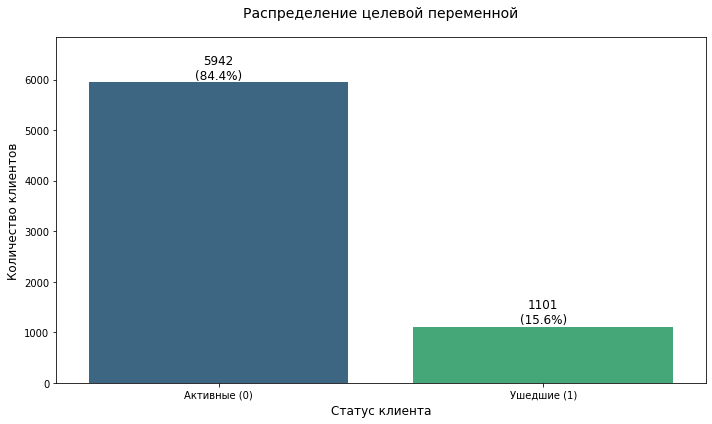

In [ ]:
#Построим гистограмму распределения целевой переменной
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='target', data=contract, palette='viridis')

total = len(contract)
for p in ax.patches:
    height = p.get_height()
    percentage = f'{100 * height/total:.1f}%'
    ax.text(p.get_x() + p.get_width()/2.,
            height + total*0.01,
            f'{height}\n({percentage})',
            ha='center',
            fontsize=12)
plt.title('Распределение целевой переменной', fontsize=14, pad=20)
plt.xlabel('Статус клиента', fontsize=12)
plt.ylabel('Количество клиентов', fontsize=12)
plt.xticks([0, 1], ['Активные (0)', 'Ушедшие (1)'])
plt.ylim(0, max([p.get_height() for p in ax.patches]) * 1.15)
plt.tight_layout()
plt.show()

**Выводы**    
В ходе предварительного анализ данных в датасет contact был включен целевой признак target, добавлен новый входящий признак - days_since_contract - длительность договора в днях и удалены данные, которве находятся в зависимости от целевого признака - даты начала и конца договора.

# Шаг 3. Объединение датасетов и предобработка объединенного датафрейма
Объединим данные по customerID

In [ ]:
# Объединяем датасеты, сохраняя всех клиентов
df = (contract
      .merge(personal, on='customerid', how='left')
      .merge(internet, on='customerid', how='left')
      .merge(phone, on='customerid', how='left'))

# Функция для очистки строковых значений
def clean_string(value):
    if isinstance(value, str):
        value = value.strip()
        if value == "" or value == " ":
            return "unknown"
    return value

# Заполняем пропуски в категориальных столбцах
categorical_cols = ['gender', 'partner', 'dependents', 'internetservice',
                   'onlinesecurity', 'onlinebackup', 'deviceprotection',
                   'techsupport', 'streamingtv', 'streamingmovies', 'multiplelines',
                   'seniorcitizen']

# Обрабатываем все категориальные столбцы
for col in categorical_cols:
    if col in df.columns:
        # Заменяем пробелы и пустые строки, затем заполняем пропуски
        df[col] = df[col].apply(clean_string).fillna('unknown')

# Специальная обработка seniorcitizen
df['seniorcitizen'] = (df['seniorcitizen']
                       .astype(str)
                       .str.strip()  # Удаляем пробелы
                       .replace({'0.0': '0', '1.0': '1', 'nan': 'unknown', '': 'unknown'})
                       .fillna('unknown'))

# Заполняем пропуски в числовых столбцах медианным значением
numeric_cols = ['monthlycharges', 'totalcharges', 'days_since_contract']
for col in numeric_cols:
    if col in df.columns:
        # Сначала преобразуем в числовой формат, заменяя нечисловые значения на NaN
        df[col] = pd.to_numeric(df[col], errors='coerce')
        # Затем заполняем медианой
        df[col] = df[col].fillna(df[col].median())

# Проверяем результат
display (f"Общее количество клиентов: {len(df)}")
display("Количество пропусков после обработки:")
display(df.isnull().sum())

display("Уникальные значения в категориальных столбцах:")
for col in categorical_cols:
    if col in df.columns:
        display(f"{col}:")
        display(df[col].value_counts(dropna=False).head())

display("Первые 5 строк результирующего датасета:")
display(df.head())

'Общее количество клиентов: 7043'

'Количество пропусков после обработки:'

customerid             0
type                   0
paperlessbilling       0
paymentmethod          0
monthlycharges         0
totalcharges           0
days_since_contract    0
target                 0
gender                 0
seniorcitizen          0
partner                0
dependents             0
internetservice        0
onlinesecurity         0
onlinebackup           0
deviceprotection       0
techsupport            0
streamingtv            0
streamingmovies        0
multiplelines          0
dtype: int64

'Уникальные значения в категориальных столбцах:'

'gender:'

Male      3555
Female    3488
Name: gender, dtype: int64

'partner:'

No     3641
Yes    3402
Name: partner, dtype: int64

'dependents:'

No     4933
Yes    2110
Name: dependents, dtype: int64

'internetservice:'

Fiber optic    3096
DSL            2421
unknown        1526
Name: internetservice, dtype: int64

'onlinesecurity:'

No         3498
Yes        2019
unknown    1526
Name: onlinesecurity, dtype: int64

'onlinebackup:'

No         3088
Yes        2429
unknown    1526
Name: onlinebackup, dtype: int64

'deviceprotection:'

No         3095
Yes        2422
unknown    1526
Name: deviceprotection, dtype: int64

'techsupport:'

No         3473
Yes        2044
unknown    1526
Name: techsupport, dtype: int64

'streamingtv:'

No         2810
Yes        2707
unknown    1526
Name: streamingtv, dtype: int64

'streamingmovies:'

No         2785
Yes        2732
unknown    1526
Name: streamingmovies, dtype: int64

'multiplelines:'

No         3390
Yes        2971
unknown     682
Name: multiplelines, dtype: int64

'seniorcitizen:'

0    5901
1    1142
Name: seniorcitizen, dtype: int64

'Первые 5 строк результирующего датасета:'

,customerid,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,days_since_contract,target,gender,seniorcitizen,partner,dependents,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,multiplelines
0,7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,31.04,31,0,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,unknown
1,5575-GNVDE,One year,No,Mailed check,56.95,2071.84,1036,0,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,226.17,123,0,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1960.60,1371,0,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,unknown
4,9237-HQITU,Month-to-month,Yes,Electronic check,70.70,353.50,153,0,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


In [ ]:
df.describe()

,monthlycharges,totalcharges,days_since_contract,target
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,64.761692,2117.413982,898.555729,0.156325
std,30.090047,2111.306354,683.130510,0.363189
min,18.250000,19.050000,0.000000,0.000000
25%,35.500000,440.495000,276.000000,0.000000
50%,70.350000,1345.275000,761.000000,0.000000
75%,89.850000,3236.690000,1461.000000,0.000000
max,118.750000,9221.380000,2314.000000,1.000000


In [ ]:
# Проверим данные на дисбаланс классов (целевой переменной)
df['target'].value_counts(normalize=True)

0    0.843675
1    0.156325
Name: target, dtype: float64

**Выводы:**  
В ходе объединения датасетов получен результирующий датесет df, в котором отсутствуют пропуски в категариальных и числовых данных, которые могли бы появиться, т.к в исходных данных (в двух датасетах) было меньше значений, чем в датасете с целевым признаком.  Поэтому при объединении данных мы заменили отсутствующие значения в категориальных прихнаках значением unknown, а числовые - медианным.  

# Шаг 4. Исследовательский анализ результирующего датасета

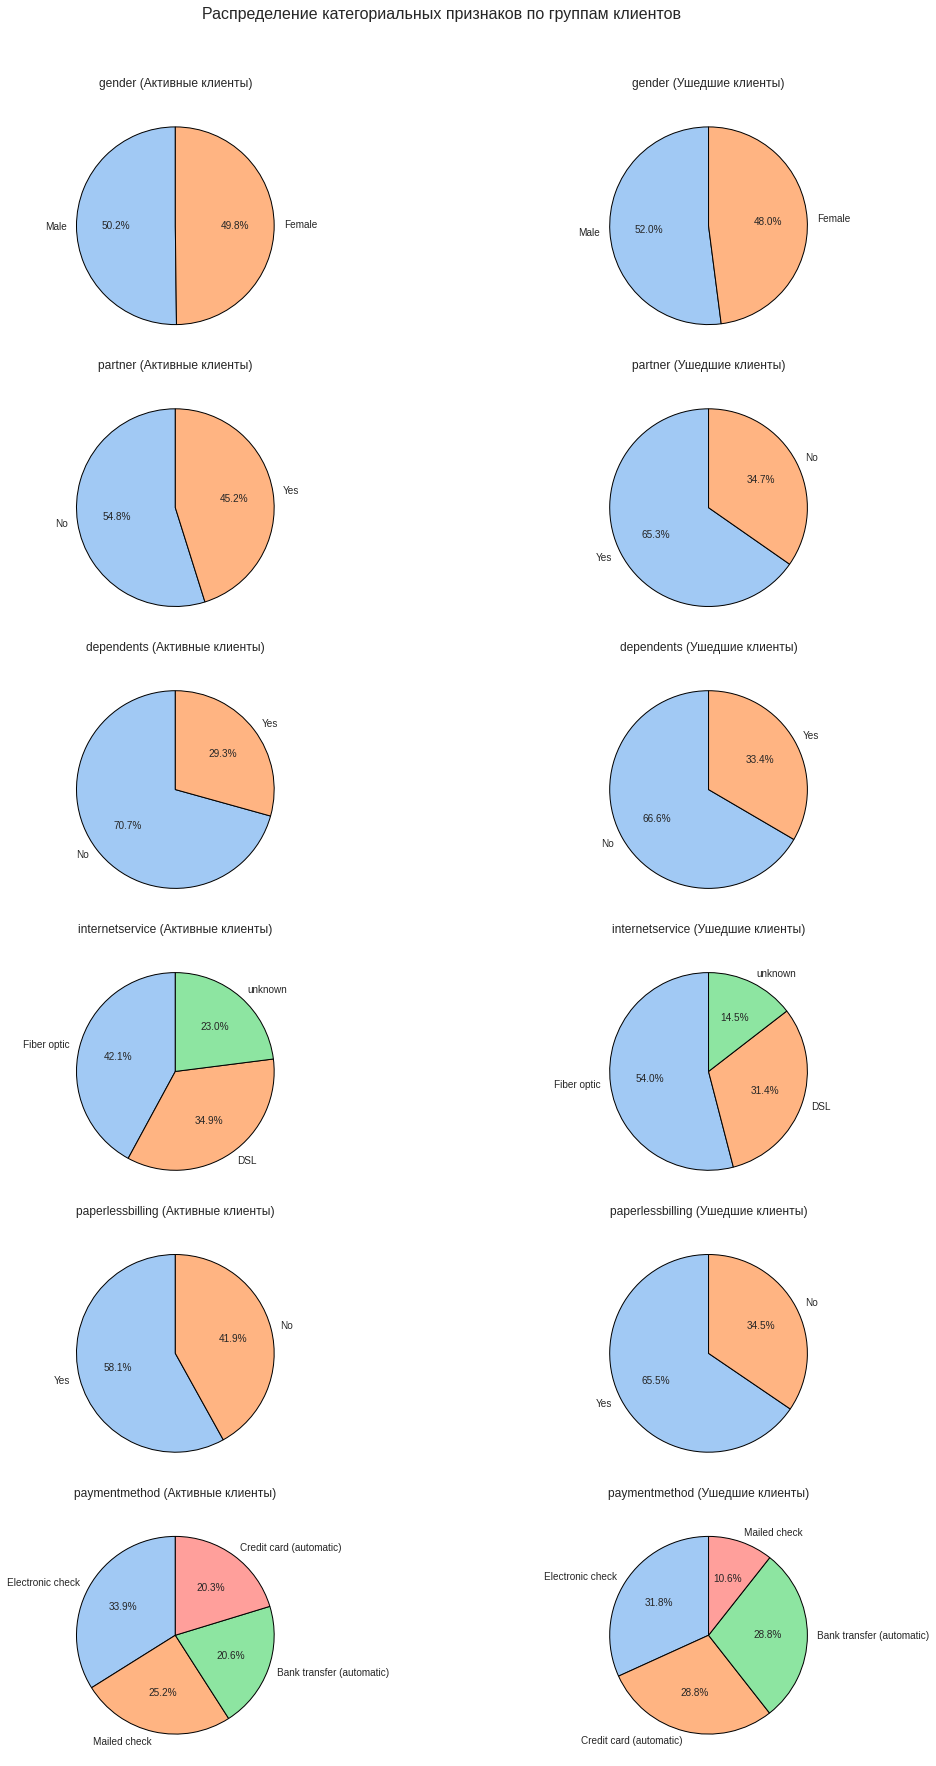

In [ ]:
plt.style.use('seaborn')
sns.set_palette("pastel")

# Список категориальных признаков
cat_features = ['gender', 'partner', 'dependents', 'internetservice',
                'paperlessbilling', 'paymentmethod']

fig, axes = plt.subplots(len(cat_features), 2, figsize=(16, len(cat_features)*4))
fig.suptitle('Распределение категориальных признаков по группам клиентов', fontsize=16, y=1.02)

# Проходим по всем категориальным признакам
for i, feature in enumerate(cat_features):
    # Данные для активных клиентов (target=0)
    data_0 = df[df['target']==0][feature].value_counts()

    # Данные для ушедших клиентов (target=1)
    data_1 = df[df['target']==1][feature].value_counts()

    # Круговая диаграмма для активных клиентов
    axes[i, 0].pie(data_0, labels=data_0.index, autopct='%1.1f%%',
                 startangle=90, wedgeprops={'edgecolor': 'black', 'linewidth': 1})
    axes[i, 0].set_title(f'{feature} (Активные клиенты)', pad=15)

    # Круговая диаграмма для ушедших клиентов
    axes[i, 1].pie(data_1, labels=data_1.index, autopct='%1.1f%%',
                 startangle=90, wedgeprops={'edgecolor': 'black', 'linewidth': 1})
    axes[i, 1].set_title(f'{feature} (Ушедшие клиенты)', pad=15)

plt.tight_layout()
plt.show()

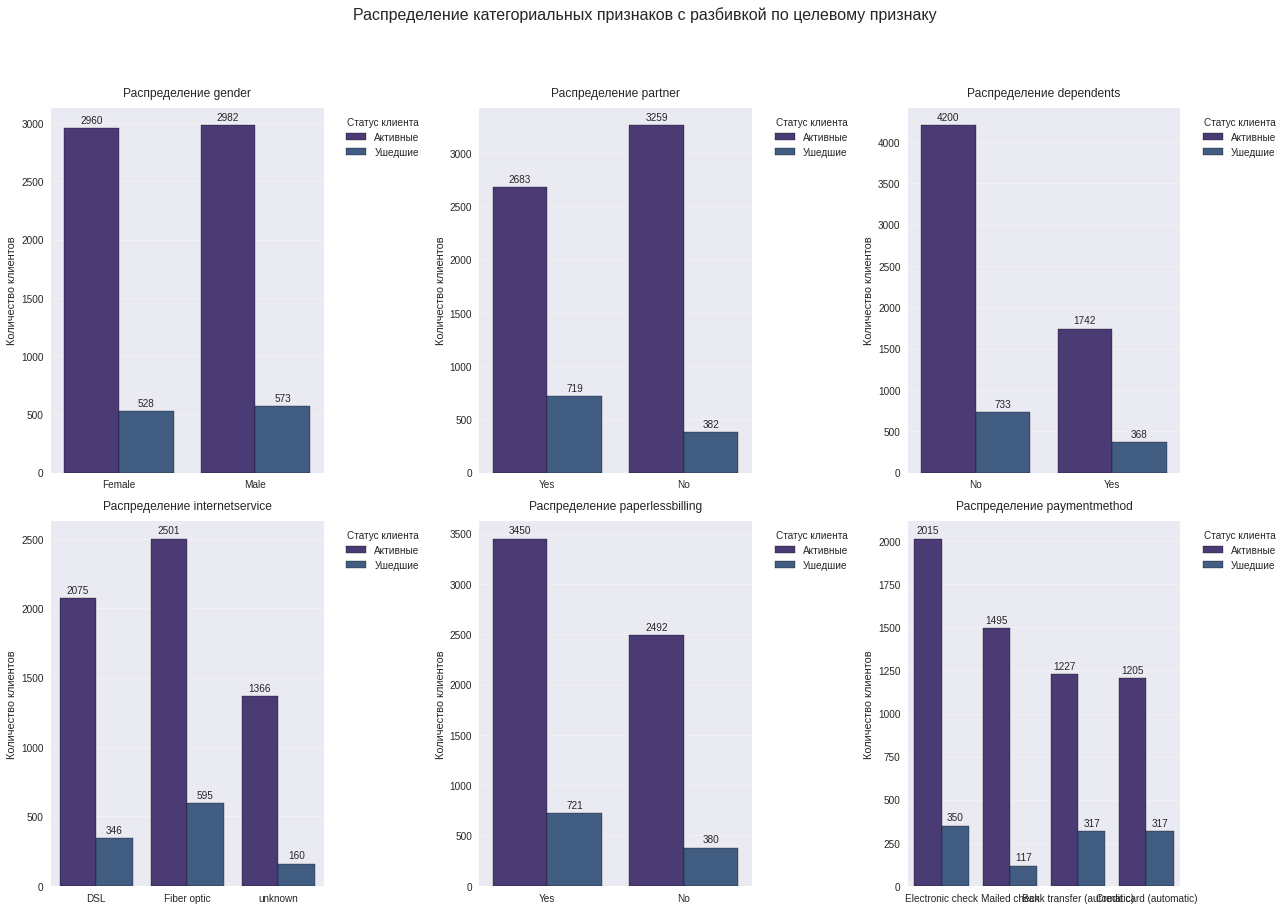

In [ ]:
plt.style.use('seaborn')
sns.set_palette("viridis")

# Список категориальных признаков для анализа
cat_features = ['gender', 'partner', 'dependents', 'internetservice',
                'paperlessbilling', 'paymentmethod']

# Создаем подграфики
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Распределение категориальных признаков с разбивкой по целевому признаку',
             fontsize=16, y=1.05)

# Проходим по всем категориальным признакам
for i, feature in enumerate(cat_features):
    row = i // 3
    col = i % 3
    # Строим countplot
    ax = sns.countplot(data=df, x=feature, hue='target',
                      ax=axes[row, col], edgecolor='black')
    # Настройка отображения
    ax.set_title(f'Распределение {feature}', pad=12)
    ax.set_xlabel('')
    ax.set_ylabel('Количество клиентов')
    ax.grid(True, axis='y', alpha=0.3)
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{int(height)}',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom',
                    xytext=(0, 3), textcoords='offset points')
    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend(handles, ['Активные', 'Ушедшие'],
                 title='Статус клиента',
                 bbox_to_anchor=(1.05, 1),
                 loc='upper left')

plt.tight_layout()
plt.show();

Ушедшие клиенты:
- на 2% больше мужчин  
- на 10% чаще имеют супруга
- на 4% меньше не имеют детей
- на 12% чаше пользуются fiber optic
- на 7 % чаще используют электронный расчетный лист
- на 3% с электронной оплатой и на 8% с кредитной картой (автоматич.)

Построим график распределения числовых признаков относительно целевого

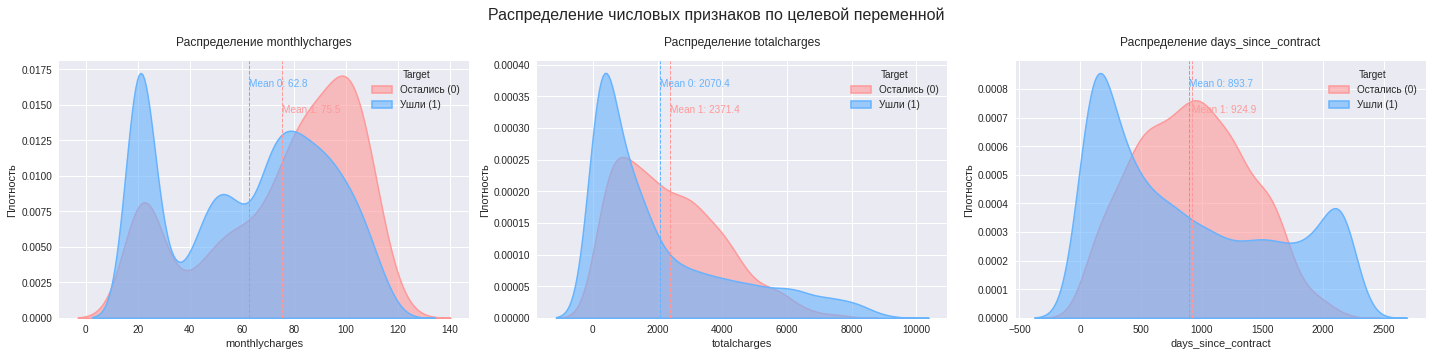

In [ ]:
# Список числовых признаков
num_features = ['monthlycharges', 'totalcharges', 'days_since_contract']

# Создаем подграфики
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle('Распределение числовых признаков по целевой переменной', fontsize=16)

# Проходим по всем числовым признакам
for i, feature in enumerate(num_features):
    # Строим KDE для каждого значения target
    sns.kdeplot(data=df, x=feature, hue='target',
                palette=['#66b3ff', '#ff9999'],
                fill=True, common_norm=False,
                alpha=0.6, linewidth=1.5,
                ax=axes[i])

    # Настройка отображения
    axes[i].set_title(f'Распределение {feature}', pad=15)
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Плотность')
    axes[i].legend(title='Target', labels=['Остались (0)', 'Ушли (1)'])

    # Добавляем средние значения
    mean_0 = df[df['target']==0][feature].mean()
    mean_1 = df[df['target']==1][feature].mean()

    axes[i].axvline(mean_0, color='#66b3ff', linestyle='--', linewidth=1)
    axes[i].axvline(mean_1, color='#ff9999', linestyle='--', linewidth=1)
    axes[i].text(mean_0, axes[i].get_ylim()[1]*0.9, f'Mean 0: {mean_0:.1f}', color='#66b3ff')
    axes[i].text(mean_1, axes[i].get_ylim()[1]*0.8, f'Mean 1: {mean_1:.1f}', color='#ff9999')

plt.tight_layout()
plt.show();

Для ушедших клиентов характерно:   
- Monthlycharges и totalcharges  (расходы за месяц и общие) обычно ниже, чем для активных.
- отключаются преимущественнов в первые 450 дней или через 1800 дней примерно

Проверим признаки на выбросы. Построим графи - ящик с усами с разбивкой по целевому признаку.

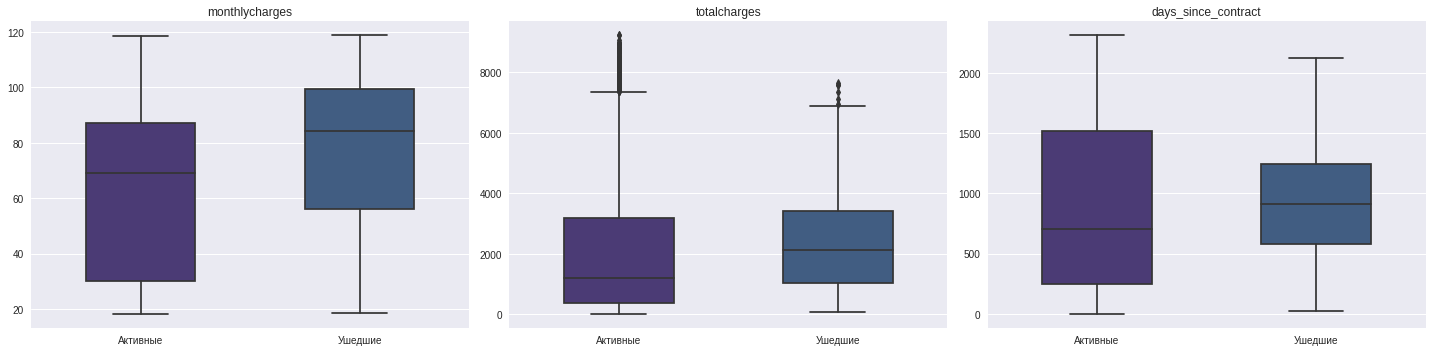

In [ ]:
plt.figure(figsize=(20, 5))
# Проходим по всем числовым столбцам
for i, col in enumerate(['monthlycharges', 'totalcharges', 'days_since_contract'], 1):
    plt.subplot(1, 3, i)

# Строим boxplot с разделением по целевому признаку
    sns.boxplot(data=df, x='target', y=col, width=0.5)

# Простые подписи
    plt.title(col)
    plt.xlabel('')
    plt.xticks([0, 1], ['Активные', 'Ушедшие'])
    plt.ylabel('')

plt.tight_layout()
plt.show()

Выбросы обнаружены в данных с общими расходами (totalcharges) - это данные выше 7500 (примерно)

In [ ]:
# Проверим кол-во пользователей по общим расходам (свыше 7500)
df['spending_group'] = pd.cut(df['totalcharges'],
                             bins=[0, 7500, float('inf')],
                             labels=['≤7500', '>7500'])

# Считаем количество по группам
spending_stats = df.groupby(['spending_group', 'target']).size().unstack()
spending_stats.columns = ['Активные', 'Ушедшие']

display ("Количество клиентов по уровню расходов:")
display(spending_stats)

'Количество клиентов по уровню расходов:'

,Активные,Ушедшие
spending_group,,
≤7500,5764,1098
>7500,178,3


Выбросов мало, оставим.

**Выводы:**
Для ушедших клиентов характерно:   
- Monthlycharges и totalcharges  (расходы за месяц и общие) обычно ниже, чем для активных.   
- отключаются преимущественнов в первые 450 дней или через 1800 дней примерно   

Ушедшие клиенты:
- на 2% больше мужчин  
- на 10% чаще имеют супруга
- на 4% меньше не имеют детей
- на 12% чаше пользуются fiber optic
- на 7 % чаще используют электронный расчетный лист   

Были обнаружены аномалии. Т.к. значений мало, то было принято рещение оставить их в датасете, чтобы не потерять данныые.  

# Шаг 5. Кореляционный анализ признаков

/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable customerid is large: 7043. Are you sure this is not an interval variable? Analysis for pairs of variables including customerid can be slow.
  warnings.warn(


<Figure size 1152x1008 with 0 Axes>

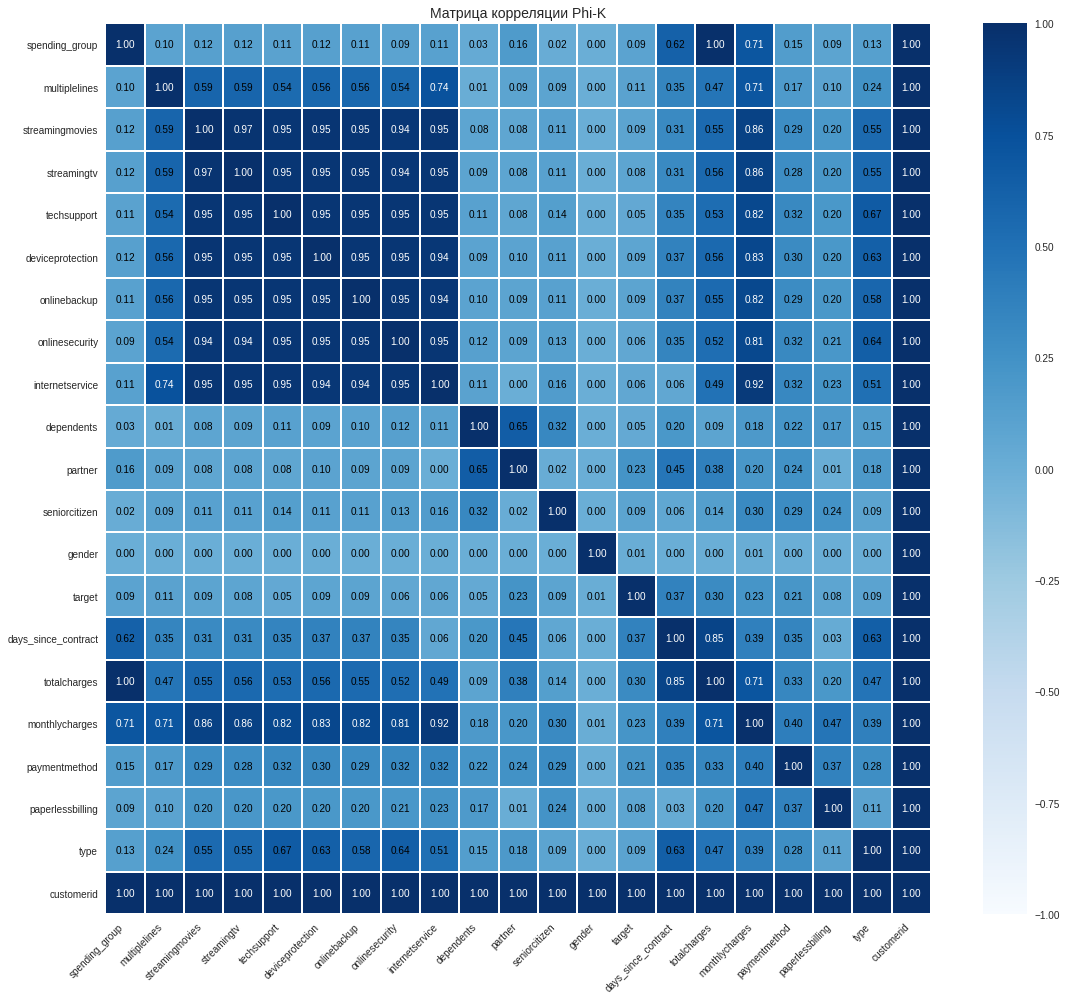

'Топ-10 признаков по корреляции с целевой переменной:'

,Корреляция с Target
target,1.000000
days_since_contract,0.374569
totalcharges,0.303451
partner,0.226688
monthlycharges,0.225925
paymentmethod,0.214832
multiplelines,0.105101
spending_group,0.094260
type,0.094015
onlinebackup,0.089704


In [ ]:
# Проверка и подготовка данных
def prepare_for_phik(df, numeric_cols):
    # Создаем копию, чтобы не изменять исходные данные
    df_phik = df.copy()

    # Преобразуем категориальные признаки
    cat_cols = list(set(df.columns) - set(numeric_cols) - {'customerid'})
    df_phik[cat_cols] = df_phik[cat_cols].astype('category')

    return df_phik

numeric_cols = ['monthlycharges', 'totalcharges', 'days_since_contract']

# Подготовка данных
df_prepared = prepare_for_phik(df, numeric_cols)

# Вычисление матрицы корреляции
corr_matrix = df_prepared.phik_matrix(interval_cols=numeric_cols)

# Визуализация
plt.figure(figsize=(16, 14))
plot_correlation_matrix(corr_matrix.values,
                       x_labels=corr_matrix.columns,
                       y_labels=corr_matrix.index,
                       color_map='Blues',
                       title='Матрица корреляции Phi-K',
                       figsize=(16, 14))
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show();

# Анализ корреляции с целевой переменной
target_corr = corr_matrix['target'].sort_values(key=abs, ascending=False)
display ("Топ-10 признаков по корреляции с целевой переменной:")
display(target_corr[1:11].to_frame('Корреляция с Target'))

**Выводы:**   
В ходе корреляционного анализа выявлена зависисимость целевой переменной и следующих признаков: days_since_contract, totalcharges. Слабая зависимость с partner, monthlycharges, paymentmethod

# Шаг 5. Подготовка данных

Следуем описанной стратегии для выбора модели:  
- Разделяем выборку на train и test  
- Обучающем все модели на выборке train, делаем кросс-валидацию и смотрим метрику  
- Сравниваем метрики на кросс-валидации, выбираем лучшую модель и ее гиперпараметры  
- Лучшую модель проверяем на тестовой выборке, можно также построить ROC-кривую.  

In [ ]:
#Целевой признак и входящие
X = df.drop(columns=['target', 'customerid'] )
y = df['target']

#Разделим датасет на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y)

#Определение типов признаков
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns

#Создание трансформеров
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(drop='if_binary'), categorical_cols)])

#Кодирование и масштабирование тренировочных данных
X_train_processed = preprocessor.fit_transform(X_train)

#Применение преобразователя к тестовым данным
X_test_processed = preprocessor.transform(X_test)

In [ ]:
#Проверка результатов
display("Размеры выборок:")
display(f"Train: {X_train_processed.shape}, Test: {X_test_processed.shape}")

'Размеры выборок:'

'Train: (5282, 40), Test: (1761, 40)'

# Шаг 6. Обучение моделей

Для решения задачи классификации выберем несколько моделей (Логистическую регрессию, Случайный лес и CatBoost). В качестве метрики для определения лучшей модели (по заданию) будем использовать Roc-auc. Дополнительно будем вычислять метрику Precision, т.к. нам важно, чтобы точность определения модели положительного класса как положительного была высокая (target = 1).

LogisticRegression

In [ ]:
# Инициализация модели LogisticRegression
model = LogisticRegression(
    class_weight='balanced',
    random_state=RANDOM_STATE,
    max_iter=1000,
    solver='liblinear',
    verbose=0)

# Кросс-валидация
cv_results = cross_validate(
    model,
    X_train_processed,
    y_train,
    scoring={
        'roc_auc': 'roc_auc_ovr',
        'precision': 'precision'
    },
    cv=5,
    n_jobs=-1,
    return_train_score=False)

#Обучение модели
model.fit(X_train_processed, y_train)

# Результаты
{
    'model': model,
    'cv_metrics': {
        'roc_auc': {
            'mean': round(float(np.mean(cv_results['test_roc_auc'])), 2),
            'std': round(float(np.std(cv_results['test_roc_auc'])), 2)
        },
        'precision': {
            'mean': round(float(np.mean(cv_results['test_precision'])), 2),
            'std': round(float(np.std(cv_results['test_precision'])), 2)
        }
    }
}

{'model': LogisticRegression(class_weight='balanced', max_iter=1000, random_state=300625,
                    solver='liblinear'),
 'cv_metrics': {'roc_auc': {'mean': 0.77, 'std': 0.03},
  'precision': {'mean': 0.3, 'std': 0.02}}}

RandomForestClassifier

In [ ]:
# Модель RandomForestClassifier
rf_model = RandomForestClassifier(
    class_weight={0: 1, 1: 2.5},
    random_state=RANDOM_STATE,
    n_jobs=-1,
    warm_start=True
)

param_grid = {
    'n_estimators': [620],
    'max_depth': [5,11],
    'min_samples_leaf': [4,5],
    'max_features': [0.48, 0.5, 0.52],
    'class_weight': [{0:1, 1:2.5}, {0:1, 1:2.7}]
}

#Оценки
scoring = {
    'roc_auc': 'roc_auc',
    'precision': make_scorer(precision_score, zero_division=0)
}

#GridSearchCV
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    scoring=scoring,
    refit='roc_auc',
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE),
    n_jobs=-1,
    verbose=2
)

#Обучение
grid_search.fit(X_train_processed, y_train)

# Вывод результатов
best_params = grid_search.best_params_
print(f"""
Лучшие параметры:
- n_estimators: {best_params.get('n_estimators')}
- max_depth: {best_params.get('max_depth')}
- min_samples_leaf: {best_params.get('min_samples_leaf')}

Метрики (3-fold CV):
- ROC-AUC: {grid_search.best_score_:.4f}
- Precision: {grid_search.cv_results_['mean_test_precision'][grid_search.best_index_]:.4f}
""")

CatBoostClassifier

In [ ]:
# Инициализация CatBoost
catboost_model = CatBoostClassifier(
    early_stopping_rounds=15,
    random_state=RANDOM_STATE,
    verbose=0,
    task_type='CPU',
    bootstrap_type='Bernoulli'
)

# Уточненная сетка параметров
param_grid = {
    'iterations': [200, 500],
    'depth': [5, 6],
    'learning_rate': [0.05, 0.1, 0.2],
    'l2_leaf_reg': [6, 7],
    'subsample': [0.75, 0.8],
    'min_data_in_leaf': [15, 20],
    'scale_pos_weight': [2.8, 3],
    'max_bin': [128, 200]
}

# Кросс-валидация
train_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

grid_search = GridSearchCV(
    estimator=catboost_model,
    param_grid=param_grid,
    scoring={'roc_auc': 'roc_auc', 'precision': make_scorer(precision_score, zero_division=0)},
    cv=train_cv,
    refit='roc_auc',
    n_jobs=-1,
    verbose=2
)

# Обучение
start_time = time.time()
grid_search.fit(X_train_processed, y_train)


Fitting 3 folds for each of 384 candidates, totalling 1152 fits
[CV] END depth=5, iterations=200, l2_leaf_reg=6, learning_rate=0.05, max_bin=128, min_data_in_leaf=15, scale_pos_weight=2.8, subsample=0.75; total time=   1.7s
[CV] END depth=5, iterations=200, l2_leaf_reg=6, learning_rate=0.05, max_bin=128, min_data_in_leaf=15, scale_pos_weight=2.8, subsample=0.75; total time=   1.4s
[CV] END depth=5, iterations=200, l2_leaf_reg=6, learning_rate=0.05, max_bin=128, min_data_in_leaf=15, scale_pos_weight=2.8, subsample=0.75; total time=   1.3s
[CV] END depth=5, iterations=200, l2_leaf_reg=6, learning_rate=0.05, max_bin=128, min_data_in_leaf=15, scale_pos_weight=2.8, subsample=0.8; total time=   1.6s
[CV] END depth=5, iterations=200, l2_leaf_reg=6, learning_rate=0.05, max_bin=128, min_data_in_leaf=15, scale_pos_weight=2.8, subsample=0.8; total time=   1.6s
[CV] END depth=5, iterations=200, l2_leaf_reg=6, learning_rate=0.05, max_bin=128, min_data_in_leaf=15, scale_pos_weight=2.8, subsample=0.8

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=300625, shuffle=True),
             estimator=<catboost.core.CatBoostClassifier object at 0x7f708329c7f0>,
             n_jobs=-1,
             param_grid={'depth': [5, 6], 'iterations': [200, 500],
                         'l2_leaf_reg': [6, 7],
                         'learning_rate': [0.05, 0.1, 0.2],
                         'max_bin': [128, 200], 'min_data_in_leaf': [15, 20],
                         'scale_pos_weight': [2.8, 3],
                         'subsample': [0.75, 0.8]},
             refit='roc_auc',
             scoring={'precision': make_scorer(precision_score, response_method='predict', zero_division=0),
                      'roc_auc': 'roc_auc'},
             verbose=2)

In [ ]:
display (f"Время обучения: {time.time()-start_time:.1f} секунд")

# Лучшая модель
best_model = grid_search.best_estimator_

# Вывод метрик
display("Результаты кросс-валидации на тренировочных данных:")
display(f"Лучший ROC-AUC: {grid_search.best_score_:.3f}")
display(f"Лучший Precision: {grid_search.cv_results_['mean_test_precision'][grid_search.best_index_]:.3f}")
display("Лучшие параметры:", grid_search.best_params_)

'Время обучения: 3871.9 секунд'

'Результаты кросс-валидации на тренировочных данных:'

'Лучший ROC-AUC: 0.879'

'Лучший Precision: 0.659'

'Лучшие параметры:'

{'depth': 5,
 'iterations': 500,
 'l2_leaf_reg': 6,
 'learning_rate': 0.2,
 'max_bin': 200,
 'min_data_in_leaf': 15,
 'scale_pos_weight': 2.8,
 'subsample': 0.8}

**Выводы:**   
По ROC-AUC (основная метрика):
Лучшая модель (по метрике ROC-AUC): CatBoost (0.879)  
RandomForest показывает похожий результат (0.82)  
LogisticRegression значительно уступает (0.77)  

По Precision:  
Снова лидирует CatBoost  (0.66)   
RandomForest на втором месте  (0.483)
LogisticRegression имеет низкую точность (0.3)  

Доп. наблюдения:

- Модели CatBoost и Logistic Regression показывают низкие значения Precision (30-47%), что характерно для несбалансированных классов в данных. Наиболее высокий показатель Regression у RandomForest (53%) – это неплохой результат для несбалансированных данных.    

# Шаг 7. Выбор лучшей модели

**Вывод:**  
Лучшая модель - CatBoost, так как она:  
- Имеет наивысший ROC-AUC на тренировочных данных (0.88)  
- Показывает хорошее значение метрики Precision (0.66)  

 Оценка лучшей модели (CatBoost) на тестовой выборке

In [ ]:
# Предсказания CatBoost на тестовых данных
test_preds = best_model.predict(X_test_processed)
test_probs = best_model.predict_proba(X_test_processed)[:, 1]

# Вычисление метрик
test_roc_auc = roc_auc_score(y_test, test_probs)
test_precision = precision_score(y_test, test_preds)

# Вывод результатов
display ("Оценка CatBoost на тестовой выборке:")
display(f"ROC-AUC: {test_roc_auc:.3f}")
display(f"Precision: {test_precision:.3f}")

'Оценка CatBoost на тестовой выборке:'

'ROC-AUC: 0.909'

'Precision: 0.726'

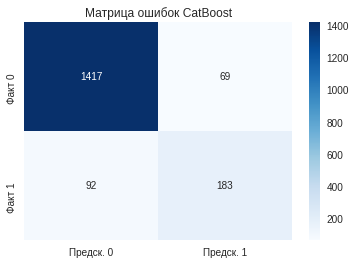

In [ ]:
# Матрица ошибок
cm = confusion_matrix(y_test, test_preds)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Предск. 0', 'Предск. 1'],
            yticklabels=['Факт 0', 'Факт 1'])
plt.title('Матрица ошибок CatBoost')
plt.show()

Выбранная модель CatBoost на тесте показала лучший результат (0.91), чем на тренировочных данных (0.88).  И отличный показатель по Precision = 0.73

Посмотрим, какие признаки для модели оказались наиболее важными

In [ ]:
#Получаем важность признаков
feature_importances = best_model.get_feature_importance()
feature_names = X_train.columns.tolist()

#Проверка соответствия размеров
if len(feature_names) != len(feature_importances):
    min_length = min(len(feature_names), len(feature_importances))
    feature_names = feature_names[:min_length]
    feature_importances = feature_importances[:min_length]

fi_df = pd.DataFrame({
    'Признак': feature_names,
    'Важность': feature_importances
}).sort_values('Важность', ascending=False)

# Выводим результаты
display("Топ-10 важных признаков:")
display(fi_df.head(10))

'Топ-10 важных признаков:'

,Признак,Важность
2,paymentmethod,44.436789
0,type,11.407844
1,paperlessbilling,10.715487
13,deviceprotection,3.160693
3,monthlycharges,3.014044
5,days_since_contract,2.479888
11,onlinesecurity,1.995529
14,techsupport,1.853575
10,internetservice,1.723114
6,gender,1.675445


Наиболее важные признаки:  
- paymentmethod — тип платежа;
- type — тип оплаты: раз в год-два или ежемесячно;  
- paperlessbilling — электронный расчётный лист;
- deviceprotection — антивирус;
- monthlycharges — расходы за месяц;  
- days_since_contrac - кол-во дней работы по договору

Выводы по лучшей модели CatBoost:
1. Общая эффективность модели  - ROC-AUC = 0.91  

2. Модель демонстрирует очень хорошее качество разделения классов (значения >0.8 считаются сильными).  

3. Результат на тесте даже выше, чем на кросс-валидации, что говорит о хорошей обобщающей способности.  

4. Precision = 0.73 73% предсказанных положительных классов ("1") оказались верными. Это почти идеально, такой показатель вполне приемлем для несбалансированных данных.  


# Шаг 8. Выводы и рекомендации

В ходе работы над проектом предоставленные данные по клиентам и доп. инфо была загружена в 4 датасета, проведена предобработка данных и предварительный анализ. Далее был подготовлен объединенный датасет и проведен его исследовательский анализ. Обучены 3 модели на тренировочных данных, выбрана лучшая модель и проведена проверка на тестовых данных.  Выбрана лучшая модель, которая готова к использованию на проме, чтобы помочь определять клиентов, планирующих отключиться от договора.  

Лучшая модель: CatBoost (ROC-AUC = 0.853, Precision = 0.47).

Рекомендации для бизнеса:обращать внимание на наиболее важные признаки клиентов, которые могут уйти:  
PaymentMethod — тип платежа;   
- выше риск на 3% с электронной оплатой и на 8% с кредитной картой (автоматич.)  

PaperlessBilling — электронный расчётный лист;  
- выше риск на 7 %, кто чаще используют электронный расчетный лист  

Для предсказанных моделью клиентов (с высоким риском ухода)  заблаговременно предлагать специальные предложения и бонусы, чтобы избежать оттока клиентов.